In [1]:
using Lazy
using DataFrames
using Memoize




Use "[]" instead.

Use "[]" instead.

Use "[]" instead.

Use "Dict{Any,Any}(a=>b, ...)" instead.

Use "Dict{Any,Any}(a=>b, ...)" instead.

Use "Dict{Any,Any}(a=>b, ...)" instead.
 in depwarn at ./deprecated.jl:40
 in oldstyle_vcat_warning at ./abstractarray.jl:26
 in vect at abstractarray.jl:29
 in include at ./boot.jl:249
 in include_from_node1 at ./loading.jl:128
 in include at ./boot.jl:249
 in include_from_node1 at ./loading.jl:128
 in reload_path at ./loading.jl:152
 in _require at ./loading.jl:67
 in require at ./loading.jl:54
 in include at ./boot.jl:249
 in include_from_node1 at ./loading.jl:128
 in reload_path at ./loading.jl:152
 in _require at ./loading.jl:67
 in require at ./loading.jl:54
 in include at ./boot.jl:249
 in include_from_node1 at ./loading.jl:128
 in include at ./boot.jl:249
 in include_from_node1 at ./loading.jl:128
 in reload_path at ./loading.jl:152
 in _require at ./loading.jl:67
 in require at ./loading.jl:52
 in include_string at loading.jl:97
 in execut

In [2]:
function load_embeddings(embedding_file)
    embeddings = Dict{String,Vector{Float64}}()
    sizehint!(embeddings, 268810)
    for line in eachline(open(embedding_file))
        fields = line |> split
        word = fields[1]
        vec = map(parsefloat, fields[2:end])
        embeddings[word] = vec
    end
    embeddings
end

load_embeddings (generic function with 1 method)

In [3]:
type WordEmbeddingResolver
    word2vec::Dict{String,Vector{Float64}}
    oov_vec::Vector{Float64} 
    
end


function WordEmbeddingResolver(embedding_file::String)
    word2vec = load_embeddings(embedding_file)
    oov_vec = zeros(size(word2vec["the"])) #Default it to zeros
    WordEmbeddingResolver(word2vec, oov_vec)
end

function WordEmbeddingResolver(embedding_file::String, oov_word::String)
    word2vec = load_embeddings(embedding_file)
    oov_vec = pop!(word2vec, oov_word)
    print(oov_vec)
    WordEmbeddingResolver(word2vec, oov_vec)
end

@doc """Returns the vector embeeding for the wordkey. If not found returns the oov_vec""" ->
function getindex(resolver::WordEmbeddingResolver, word::String)
    get(resolver.word2vec, word, resolver.oov_vec) ::Vector{Float64}
end

function hasword(resolver::WordEmbeddingResolver, word::String)
    haskey(resolver.word2vec, word)
end

@memoize function vocab_words(resolver::WordEmbeddingResolver)
    Set(keys(resolver.word2vec))
end

In [22]:
#embeddings =  WordEmbeddingResolver("ACL2012_wordvectors.txt");
#embeddings =  WordEmbeddingResolver("embeddings-scaled.EMBEDDING_SIZE=50.txt", "*UNKNOWN*");
embeddings =  WordEmbeddingResolver("embeddings-scaled.EMBEDDING_SIZE=200.txt", "*UNKNOWN*");


[-0.0123697523568,-0.000305474013442,-0.0253130365759,0.0151142379354,0.00241191267527,0.0725861760336,-0.0300995435437,0.00855664144139,0.0358352520233,0.000165624593445,-0.00964849868542,0.015983963356,-0.00666431449902,0.0530545454208,0.0143174251523,0.0310568593772,-0.0211887605377,0.001482611707,-0.0242534859142,-0.0375952751069,-0.0344003166856,0.034662662654,-0.0267299321485,-0.0021610852158,-0.0224852233935,-0.0200154318555,-0.0170443218951,0.0571607730194,-0.0775846832805,0.000507893664517,0.0252554828951,0.0251121635902,0.0233163250017,-0.0918191032675,-0.0513910854002,0.0290472350527,-0.074063741815,0.000445758837627,-0.0369025817274,0.00603547784667,0.0904788418596,-0.00257913476528,-0.00277053910953,-0.0453646059453,0.0404939733258,-0.0212866454413,-0.0316684046125,0.0601451647696,0.0411315702081,0.0161787023187,0.0048506471575,-0.0788630823374,0.03212888635,0.019992401856,0.0028465284135,0.0514186364844,-0.00843945663116,-0.0302503354025,-0.0215443397753,0.0332341064792,0

In [1]:
function csl2set(comma_seperated_list::String)
    @> comma_seperated_list split(",") Set
end

function csl2set(::NAtype)
    NA
end
    

function load_con_data(name)
    con = readtable("con_data/$name.csv")
    con[:con_name] = name
    con[:tags] = map(csl2set,con[:tags])
    con[:people] = map(csl2set,con[:people])
    con
end

LoadError: LoadError: UndefVarError: @> not defined
while loading In[1], in expression starting on line 4

In [24]:
con = [load_con_data("swancon_2009");
    load_con_data("swancon_2010");
    load_con_data("swancon_2012");
    load_con_data("swancon_2013");
    load_con_data("swancon_2014");];


In [25]:
@doc "Breaks up text, in to a list of words. It will split off the suffix and prefixes into seperate words if this causes the base word to be in the preffered words list" ->
function breakup_text(  text::String, 
    preferred_words::Set{String},
    suffixes = ["",",",";",".", "n't", "'s", "'ve", "!", "*", "...", "?", ":", ")", "\""],
    prefixes = ["","(", "\""])
    
    assert("" == suffixes[1])
    assert("" == prefixes[1])
    
    unpreferred_words = Array{String}(0)
    words = Array{String}(0)
    for field in split(text)
        found = false
        for pre in prefixes, suf in suffixes #The straight word is covered by the prefix and suffix ""
            if startswith(field,pre) && endswith(field,suf)
                word = field[1+length(pre):end-length(suf)]
                #println("***[$pre][$word][$suf]")
                if word in preferred_words
                    for part in [pre,word,suf]
                        if !isempty(part)
                            push!(words,part)
                        end
                    end
                    found = true
                    break
                end
            end
        end

        if !found #(ie else prefix loop not broken) so Not a prefferd word
            push!(words,field) #Put it on the word list anyway, it will be dealt with later
            push!(unpreferred_words,field) #but also note it as a problem
        end
        
    end
    words, unpreferred_words
end

function breakup_text(::DataArrays.NAtype, ::Set{AbstractString})
   NA, NA
end

breakup_text (generic function with 4 methods)

In [26]:
function get_total_embedding(embeddings::WordEmbeddingResolver, text::String)
    words::Vector{String}= breakup_text(text, vocab_words(embeddings))[1]
    if !isempty(words)
        @>>words map(ww->embeddings[ww]) mean    
    else
        NA
    end
    
end

function get_total_embedding(embeddings::WordEmbeddingResolver, text::NAtype)
    NA
end

con[:desc_vec] = @>> con[:description] map(desc->get_total_embedding(embeddings, desc));

X dimensions are: (715,200)
Initial X Shape is : (715,200)
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 500 of 715...
Mean value of sigma: 3.0925119361520763
Iteration 10: error is -7.081941320254971e-6
Iteration 20: error is -6.96241699228494e-6
Iteration 30: error is -6.8840800600564174e-6
Iteration 40: error is -6.849237120530726e-6
Iteration 50: error is -6.836124680932835e-6
Iteration 60: error is -6.82971740561433e-6
Iteration 70: error is -6.826056535425859e-6
Iteration 80: error is -6.823751924436749e-6
Iteration 90: error is -6.822210403174979e-6
Iteration 100: error is -6.821128061993074e-6
Iteration 110: error is -1.8822605354159244e-6
Iteration 120: error is -1.8821103966283322e-6
Iteration 130: error is -1.8819944336866354e-6
Iteration 140: error is -1.8819033484394305e-6
Iteration 150: error is -1.881830666734945e-6
Iteration 160: error is -1.8817717159495819e-6
Iteration 170: error is -1.8817231165394165e-6
Iteration 18

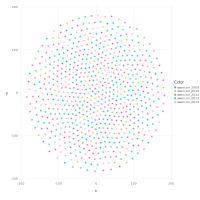

In [34]:
using Gadfly


push!(LOAD_PATH, "./TSne.jl/src/")
using TSne
set_default_plot_size(20cm, 20cm)


cleanCon = con[!isna(con[:desc_vec]),:]

X = hcat(cleanCon[:desc_vec]...)'*1000

initial_dims = 25
iterations = 200
perplexity = 50

println("X dimensions are: $(size(X))")
Y = tsne(X, 2, initial_dims, iterations, perplexity)
println("Y dimensions are: $(size(Y))")
plot(x=Y[:,1], y=Y[:,2], color=cleanCon[:con_name])


In [33]:
data = cleanCon#[cleanCon[:con_name].=="swancon_2014",:]

index = rand(1:700, 100)
labels = cleanCon[:title][index]
color=cleanCon[:con_name][index]
yy= Y[index,:]
plot(x=yy[:,1], y=yy[:,2], Guide.annotation(compose(context(), text(yy[:,1], yy[:,2], labels))), color=color)
